In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disables INFO & WARNING logs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from IPython import display
from tkinter.filedialog import askdirectory

from losses import total_loss
from maptd_model import maptd_model
from pipeline_v2 import get_dataset, get_dataset_from_txt_files

In [2]:
dataset_dir = './data/general_dataset/'
INITIAL_DIR = './data/ckpts/models'

conf_file_dir = askdirectory(initialdir=INITIAL_DIR, title='Select the directory '
    'with the configuration files')
print(conf_file_dir)

D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/ckpts/models/3


In [3]:
def show_score_map(tile, gt_score_map, pred_score_map, threshold=None):
    pred_score_map = np.where(pred_score_map > threshold, 1, 0)
    COLORMAP = 'gray'
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(np.squeeze(tf.cast(tile, tf.uint8)))
    ax[1].imshow(np.squeeze(gt_score_map), cmap=COLORMAP)
    ax[2].imshow(np.squeeze(pred_score_map), cmap=COLORMAP)
    plt.show()

In [4]:
class StepDecayLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, initial_learning_rate, decay_rate, decay_on_step):
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.decay_on_step = decay_on_step
        
    def __call__(self, step):
        new_lr = tf.cond(step < self.decay_on_step, 
                       lambda: self.initial_learning_rate,
                       lambda: self.initial_learning_rate * self.decay_rate)
        return new_lr

In [5]:
TILE_SIZE = 512
TRAIN_BATCH_SIZE = 16

# Define the model
maptd = maptd_model()

# Create log files
log_dir = os.path.join(conf_file_dir, 'logs')
sum_writer = tf.summary.create_file_writer(os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

# Initialize checkpoints
ckpt_dir = os.path.join(conf_file_dir, 'training_ckpts')
ckpt_prefix = os.path.join(ckpt_dir, 'ckpt')
ckpt = tf.train.Checkpoint(model=maptd)

In [6]:
# Load the dataset generators
train_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'train', batch_size=TRAIN_BATCH_SIZE)
test_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'test', batch_size=1)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [ ]:
#ckpt_prefix = os.path.join(ckpts_dir, 'ckpt')
#ckpt = tf.train.Checkpoint(model=maptd)
latest = tf.train.latest_checkpoint(ckpt_dir)
print(latest)
ckpt.restore(latest)

## Training

In [7]:
@tf.function()
def train_step(model, optimizer, tile, 
               score_map, geo_map, training_mask, 
               step, summary_writer):
    
    with tf.GradientTape() as tape:
        pred_score_map, pred_geo_map = model(tile, training=True)

        loss = total_loss(score_map, pred_score_map, geo_map, pred_geo_map, 
                          training_mask)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    with summary_writer.as_default():
        tf.summary.scalar('total_loss', loss, step=step)
        
    return loss

In [8]:
def fit(model, train_dataset, test_dataset, summary_writer,
        total_steps=2**20, step_to_reduce_lr=2**17, enumerate_from=0):
    initial_lr = 1e-4
    decay_rate = 0.1
    opt = tf.keras.optimizers.Adam(
        learning_rate=StepDecayLRSchedule(initial_lr, decay_rate, 
                                          step_to_reduce_lr), 
        epsilon=1e-8)
    
    training_start = time.time()
    start = training_start
    for step, (tile, score_map, geo_map, training_mask) in \
                train_dataset.repeat().take(total_steps - enumerate_from).\
                enumerate(start=enumerate_from):
        
        training_loss = train_step(model, opt, tile, 
                                    score_map, geo_map, training_mask,
                                    step, summary_writer)
        
        step = step.numpy()
        
        if (step + 1) % 500 == 0:
            display.clear_output(wait=True)
            print(datetime.datetime.now().strftime("%H:%M:%S"))            
            print(f'Step {step + 1}/{total_steps}')
            
            if step != 0 and step != enumerate_from:
                print(f'Time taken for the last 500 steps: '
                      f'{time.time()-start:.2f} sec')
                estimated_remaining_time = int((time.time() - training_start) / \
                    (step - enumerate_from) * (total_steps - step))
                print(f'Estimated time for the training to finish: '
                      f'{estimated_remaining_time // 3600} hrs, '
                      f'{int(estimated_remaining_time % 3600 / 60)} mins')
                
            print('Current Learning Rate: ', opt.lr(step))
            print(f'Training loss: {training_loss:.4f}')
            
            example_tile, example_score_map, _, _ = next(iter(test_dataset.take(1)))
            example_pred_score_map, _ = maptd(example_tile, training=True)
            show_score_map(example_tile, 
                           example_score_map, 
                           example_pred_score_map, 
                           threshold=0.9)    
            
            start = time.time()
               
        if (step + 1) == step_to_reduce_lr:
            new_lr = opt.lr(step)
            print(f'\nThe learning rate for the optimizer was decreased from '
                  f'{initial_lr} to {new_lr}')
            
        if (step + 1) % 10000 == 0:
            ckpt.save(file_prefix=ckpt_prefix)
            print(f'Checkpoint at step: {step + 1}')

13:08:17
Step 13500/1048576
Time taken for the last 500 steps: 113.10 sec
Estimated time for the training to finish: 66 hrs, 11 mins
Current Learning Rate:  0.0001
Training loss: 0.0160


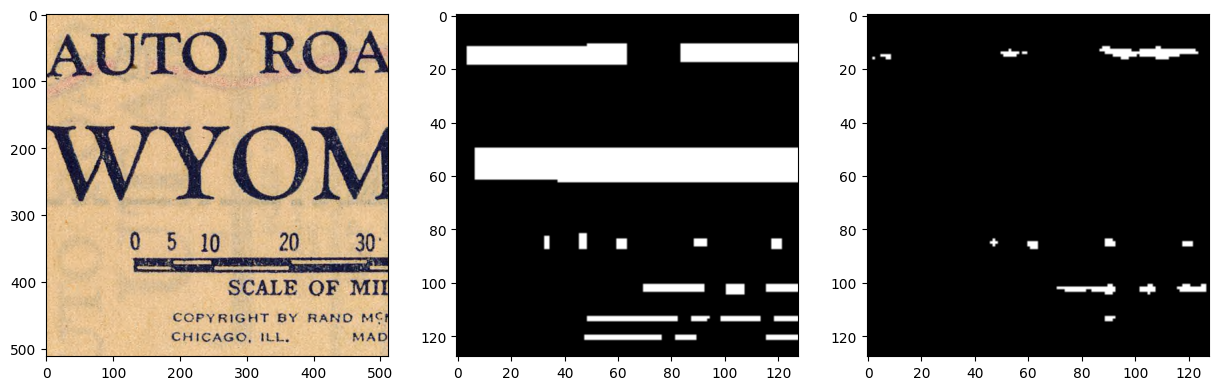

In [ ]:
# Train the model
fit(maptd, train_ds, test_ds, sum_writer)

In [ ]:
modelpath = os.path.join(conf_file_dir, 'saved_model')
maptd.save(modelpath)

In [ ]:
dataset_dir = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/general_dataset/'
test_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'test', batch_size=1)

In [ ]:
example_tile, example_score_map, _, _ = next(iter(test_ds.take(1)))

## Restore a model from a checkpoint

In [ ]:
TILE_SIZE = 512
TRAIN_BATCH_SIZE = 16

# Load the dataset generators
train_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'train', batch_size=TRAIN_BATCH_SIZE)
test_ds = get_dataset_from_txt_files(dataset_dir, conf_file_dir, 'test', batch_size=1)

# Define the model
maptd = maptd_model(input_size=TILE_SIZE)

In [ ]:
ckpts_dir = askdirectory(initialdir=INITIAL_DIR, 
                         title='Select the directory with the checkpoints')

ckpt_prefix = os.path.join(ckpts_dir, 'ckpt')
ckpt = tf.train.Checkpoint(model=maptd)
latest = tf.train.latest_checkpoint(ckpts_dir)
print(latest)
ckpt.restore(latest)

In [ ]:
conf_file_dir = 'D:/Gerasimos/Toponym_Recognition/MapTD_General/MapTD_TF2/data/ckpts/models/0'
log_dir = os.path.join(conf_file_dir, 'logs')
sum_writer = tf.summary.create_file_writer(os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [ ]:
stepnumber_to_start_from = 490000 # Because, this time, the latest ckpt is the one with number 15, i.e. 15*10000=150000 steps have ran already

# Continue on train the model
fit(maptd, train_ds, test_ds, sum_writer, enumerate_from=stepnumber_to_start_from)

In [ ]:
modelpath = os.path.join(conf_file_dir, 'saved_model')
maptd_model.save(modelpath)